In [1]:
%matplotlib inline


# The USIDataset

**Suhas Somnath**

11/11/2017

**This document illustrates how the pyUSID.USIDataset class substantially simplifies accessing information about,
slicing, and visualizing N-dimensional Universal Spectroscopy and Imaging Data (USID) Main datasets**


## USID Main Datasets
According to the **Universal Spectroscopy and Imaging Data (USID)** model, all spatial dimensions are collapsed to a
single dimension and, similarly, all spectroscopic dimensions
are also collapsed to a single dimension. Thus, the data is stored as a two-dimensional (N x P) matrix with N spatial
locations each with P spectroscopic data points.

This general and intuitive format allows imaging data from any instrument, measurement scheme, size, or dimensionality
to be represented in the same way. Such an instrument independent data format enables a single set of analysis and
processing functions to be reused for multiple image formats or modalities.

``Main datasets`` are greater than the sum of their parts. They are more capable and information-packed than
conventional datasets since they have (or are linked to) all the necessary information to describe a measured dataset.
The additional information contained / linked by ``Main datasets`` includes:

* the recorded physical quantity
* units of the data
* names of the position and spectroscopic dimensions
* dimensionality of the data in its original N dimensional form etc.

## USIDatasets = USID Main Datasets
Regardless, ``Main datasets`` are just concepts or blueprints and not concrete digital objects in a programming language
or a file. ``USIDatasets`` are **tangible representations of Main datasets**. From an implementation perspective, the
USIDataset class extends the ``h5py.Dataset object``. In other words, USIDatasets have all the capabilities of
standard HDF5 / h5py Dataset objects but are supercharged from a scientific perspective since they:

* are self-describing
* allow quick interactive visualization in Jupyter notebooks
* allow intuitive slicing of the N dimensional dataset
* and much much more.

While it is most certainly possible to access this information and enable these functionalities via the native ``h5py``
functionality, it can become tedious very quickly.  In fact, a lot of the functionality of USIDataset comes from
orchestration of multiple functions in ``pyUSID.hdf_utils`` outlined in other documents. The USIDataset class
makes such necessary information and functionality easily accessible.

Since Main datasets are the hubs of information in a USID HDF5 file (**h5USID**), we expect that the majority of
the data interrogation will happen via USIDatasets

## Recommended pre-requisite reading
* [Universal Spectroscopic and Imaging Data (USID) model](https://pycroscopy.github.io/USID/usid_model.html)
* [Crash course on HDF5 and h5py](./h5py_primer.html)
* Utilities for [reading](./hdf_utils_read.html) h5USID files using pyUSID

## Example scientific dataset

Before, we dive into the functionalities of USIDatasets we need to understand the dataset that will be used in this
example. For this example, we will be working with a Band Excitation Polarization Switching (BEPS) dataset acquired
from advanced atomic force microscopes. In the much simpler Band Excitation (BE) imaging datasets, a single spectra
is acquired at each location in a two dimensional grid of spatial locations. Thus, BE imaging datasets have two
position dimensions (X, Y) and one spectroscopic dimension (frequency - against which the spectra is recorded). The
BEPS dataset used in this example has a spectra for each combination of three other parameters (DC offset, Field, and
Cycle). Thus, this dataset has three new spectral dimensions in addition to the spectra itself. Hence, this dataset
becomes a 2+4 = 6 dimensional dataset

## Load all necessary packages

First, we need to load the necessary packages. Here are a list of packages, besides pyUSID, that will be used in
this example:

* ``h5py`` - to open and close the file
* ``wget`` - to download the example data file
* ``numpy`` - for numerical operations on arrays in memory
* ``matplotlib`` - basic visualization of data



In [2]:
from __future__ import print_function, division, unicode_literals
import os
# Warning package in case something goes wrong
from warnings import warn
import subprocess
import sys


def install(package):
    subprocess.call([sys.executable, "-m", "pip", "install", package])
# Package for downloading online files:


try:
    # This package is not part of anaconda and may need to be installed.
    import wget
except ImportError:
    warn('wget not found.  Will install with pip.')
    import pip
    install('wget')
    import wget
import h5py
import numpy as np
import matplotlib.pyplot as plt

try:
    import sidpy
except ImportError:
    warn('sidpy not found.  Will install with pip.')
    import pip
    install('sidpy')
    import sidpy

try:
    import pyUSID as usid
except ImportError:
    warn('pyUSID not found.  Will install with pip.')
    import pip
    install('pyUSID')
    import pyUSID as usid

## Load the dataset
First, lets download example h5USID file from the pyUSID Github project:



In [3]:
url = 'https://raw.githubusercontent.com/pycroscopy/pyUSID/master/data/BEPS_small.h5'
h5_path = 'temp.h5'
_ = wget.download(url, h5_path, bar=None)

print('Working on:\n' + h5_path)

Working on:
temp.h5


Next, lets open this HDF5 file in read-only mode. Note that opening the file does not cause the contents to be
automatically loaded to memory. Instead, we are presented with objects that refer to specific HDF5 datasets,
attributes or groups in the file



In [4]:
h5_path = 'temp.h5'
h5_f = h5py.File(h5_path, mode='r')

Here, ``h5_f`` is an active handle to the open file.
Lets quickly look at the contents of this HDF5 file using a handy function in ``pyUSID.hdf_utils`` - ``print_tree()``



In [5]:
print('Contents of the H5 file:')
sidpy.hdf_utils.print_tree(h5_f)

Contents of the H5 file:
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-SHO_Fit_000
      --------------------
      ├ Fit
      ├ Guess
      ├ Spectroscopic_Indices
      ├ Spectroscopic_Values
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Mean_Spectrogram
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices


For this example, we will only focus on the ``Raw_Data`` dataset which contains the 6D raw measurement data. First lets
access the HDF5 dataset and check if it is a ``Main`` dataset in the first place:



In [6]:
h5_raw = h5_f['/Measurement_000/Channel_000/Raw_Data']
print(h5_raw)
print('h5_raw is a main dataset? {}'.format(usid.hdf_utils.check_if_main(h5_raw)))

<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">
h5_raw is a main dataset? True


It turns out that this is indeed a Main dataset. Therefore, we can turn this in to a USIDataset without any
problems.

## Creating a USIDataset
All one needs for creating a USIDataset object is a Main dataset. Here is how we can supercharge h5_raw:



In [7]:
pd_raw = usid.USIDataset(h5_raw)
print(pd_raw)

<HDF5 dataset "Raw_Data": shape (25, 22272), type "<c8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Cantilever Vertical Deflection (V) 
Data dimensions and original shape: 
Position Dimensions: 
	X - size: 5 
	Y - size: 5 
Spectroscopic Dimensions: 
	Frequency - size: 87 
	DC_Offset - size: 64 
	Field - size: 2 
	Cycle - size: 2
Data Type:
	complex64


Notice how easy it was to create a USIDataset object. Also, note how the USIDataset is much more informative in
comparison with the conventional h5py.Dataset object.

### USIDataset = Supercharged(h5py.Dataset)
Remember that USIDataset is just an extension of the h5py.Dataset object class. Therefore, both the ``h5_raw`` and
``pd_raw`` refer to the same object as the following equality test demonstrates. Except ``pd_raw`` knows about the
``ancillary datasets`` and other information which makes it a far more powerful object for you.



In [8]:
print(pd_raw == h5_raw)

True


## Easier access to information
Since the USIDataset is aware and has handles to the supporting ancillary datasets, they can be accessed as
properties of the object unlike HDF5 datasets. Note that these ancillary datasets can be accessed using functionality
in pyUSID.hdf_utils as well. However, the USIDataset option is far easier.

Let us compare accessing the Spectroscopic Indices via the USIDataset and hdf_utils functionality:



In [9]:
h5_spec_inds_1 = pd_raw.h5_spec_inds
h5_spec_inds_2 = sidpy.hdf_utils.get_auxiliary_datasets(h5_raw, 'Spectroscopic_Indices')[0]
print(h5_spec_inds_1 == h5_spec_inds_2)

True


In the same vein, it is also easy to access **string descriptors** of the ancillary datasets and the Main dataset.
The ``hdf_utils`` alternatives to these operations / properties also exist and are discussed in an alternate document,
but will not be discussed here for brevity.:



In [10]:
print('Desctiption of physical quantity in the Main dataset:')
print(pd_raw.data_descriptor)
print('Position Dimension names and sizes:')
for name, length in zip(pd_raw.pos_dim_labels, pd_raw.pos_dim_sizes):
    print('{} : {}'.format(name, length))
print('Spectroscopic Dimension names and sizes:')
for name, length in zip(pd_raw.spec_dim_labels, pd_raw.spec_dim_sizes):
    print('{} : {}'.format(name, length))
print('Position Dimensions:')
print(pd_raw.pos_dim_descriptors)
print('Spectroscopic Dimensions:')
print(pd_raw.spec_dim_descriptors)

Desctiption of physical quantity in the Main dataset:
Cantilever Vertical Deflection (V)
Position Dimension names and sizes:
X : 5
Y : 5
Spectroscopic Dimension names and sizes:
Frequency : 87
DC_Offset : 64
Field : 2
Cycle : 2
Position Dimensions:
['X (m)', 'Y (m)']
Spectroscopic Dimensions:
['Frequency (Hz)', 'DC_Offset (V)', 'Field ()', 'Cycle ()']


## Values for each Dimension
When visualizing the data it is essential to plot the data against appropriate values on the X, Y, Z axes. The
USIDataset object makes it very easy to access the values over which a dimension was varied using the
``get_pos_values()`` and ``get_spec_values()`` functions. This functionality is enabled by the ``get_unit_values()``
function in ``pyUSID.hdf_utils``.

For example, let us say we wanted to see how the ``DC_Offset`` dimension was varied, we could:



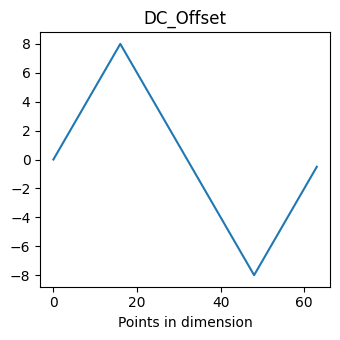

In [11]:
dim_name = 'DC_Offset'
dc_vec = pd_raw.get_spec_values(dim_name)
fig, axis = plt.subplots(figsize=(3.5, 3.5))
axis.plot(dc_vec)
axis.set_xlabel('Points in dimension')
axis.set_title(dim_name)
fig.tight_layout()

## Reshaping to N dimensions

The USID model stores N dimensional datasets in a flattened 2D form of position x spectral values. It can become
challenging to retrieve the data in its original N-dimensional form, especially for multidimensional datasets
such as the one we are working on. Fortunately, all the information regarding the dimensionality of the dataset
are contained in the spectral and position ancillary datasets. PycoDataset makes it remarkably easy to obtain the N
dimensional form of a dataset:



In [12]:
ndim_form = pd_raw.get_n_dim_form()
print('Shape of the N dimensional form of the dataset:')
print(ndim_form.shape)
print('And these are the dimensions')
print(pd_raw.n_dim_labels)

Shape of the N dimensional form of the dataset:
(5, 5, 87, 64, 2, 2)
And these are the dimensions
['X', 'Y', 'Frequency', 'DC_Offset', 'Field', 'Cycle']


## Slicing
It is often very challenging to grapple with multidimensional datasets such as the one in this example. It may not
even be possible to load the entire dataset in its 2D or N dimensional form to memory if the dataset is several (or
several hundred) gigabytes large. Slicing the 2D Main dataset can easily become confusing and frustrating. To solve
this problem, USIDataset has a ``slice()`` function that efficiently loads the only the sliced data into memory and
reshapes the data to an N dimensional form. Best of all, the slicing arguments can be provided in the actual
N dimensional form!

For example, imagine that we cannot load the entire example dataset in its N dimensional form and then slice it. Lets
try to get the spatial map for the following conditions without loading the entire dataset in its N dimensional form
and then slicing it :

* 14th index of DC Offset
* 1st index of cycle
* 0th index of Field (remember Python is 0 based)
* 43rd index of Frequency

To get this, we would slice as:



In [13]:
spat_map_1, success = pd_raw.slice({'Frequency': 43, 'DC_Offset': 14, 'Field': 0, 'Cycle': 1})

As a verification, lets try to plot the same spatial map by slicing the N dimensional form we got earlier and compare
it with what we got above:



In [14]:
spat_map_2 = np.squeeze(ndim_form[:, :, 43, 14, 0, 1])
print('2D slicing == ND slicing: {}'.format(np.allclose(spat_map_1, spat_map_2)))

2D slicing == ND slicing: True


## Interactive Visualization
USIDatasets also enable quick, interactive, and easy visualization of data up to 2 position and 2 spectroscopic
dimensions (4D datasets). Since this particular example has 6 dimensions, we would need to slice two dimensions in
order to visualize the remaining 4 dimensions. Note that this interactive visualization **only** works on Jupyter
Notebooks. This html file generated by a python script does not allow for interactive visualization and you may only
see a set of static plots. 

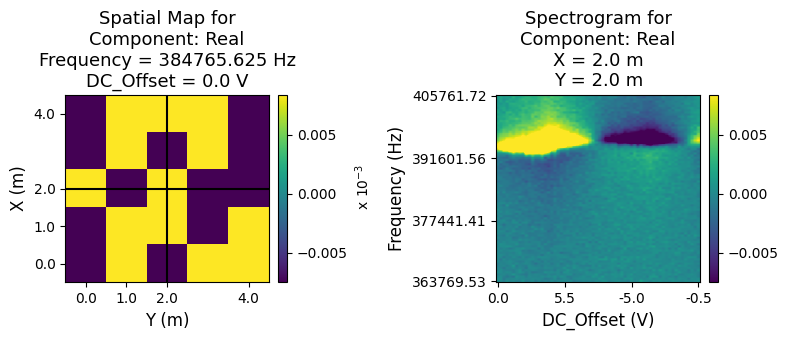

interactive(children=(IntSlider(value=2, description='X', max=4), IntSlider(value=2, description='Y', max=4), …

In [15]:
pd_raw.visualize(slice_dict={'Field': 0, 'Cycle': 1});

Close and delete the h5_file



In [16]:
h5_f.close()
os.remove(h5_path)